## Compare LM Uncertainty over a token with it's prominence 

In [26]:
import numpy as np
import os
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import json
from src.utils.stats import shannon_entropy

from src.utils.old_features import (
    get_features_from_lab_root,
    F0Extractor,
    WordDurationExtractor,
    get_duration_features_from_lab_root,
)
import scipy.io.wavfile as wav
import numpy as np
from src.utils.prosody_tools.f0_processing import _interpolate

In [27]:
CORPUS_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS/test-clean"
ALIGNMENT_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/test-clean"

In [28]:
duration_extractor = WordDurationExtractor()

In [29]:
samples = get_duration_features_from_lab_root(
    ALIGNMENT_ROOT, CORPUS_ROOT, duration_extractor
)

Readers: 100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


In [30]:
from src.data.components.feature_extractors import DurationFeatureExtractor

duration_extractor = DurationFeatureExtractor(samples)

In [31]:
train_texts = duration_extractor.get_all_texts()
train_durations = duration_extractor.get_all_durations()

In [32]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataset = TokenTaggingDataset(
    train_texts,
    train_durations,
    tokenizer,
    "gpt2",
    score_first_token=True,
    # relative_to_prev=False,
    # n_prev=3,
    # relative_to_mean=True,
    # word_stats=word_stats,
)

# test_dataset = TokenTaggingDataset(
#     test_texts,
#     test_prominences,
#     tokenizer,
#     "gpt2",
#     score_first_token=True,
#     # relative_to_prev=False,
#     # n_prev=3,
#     # relative_to_mean=True,
#     # word_stats=word_stats,
# )

In [33]:
train_texts = []
train_labels = []
train_input_ids = []
train_word_to_token = []
train_loss_masks = []

for i in tqdm(range(len(train_dataset)), desc="train", total=len(train_dataset)):
    item = train_dataset.__getitem__(i)
    train_texts.append(item["input_text"])
    train_input_ids.append(item["input_ids"])
    train_word_to_token.append(item["word_to_tokens"])
    train_loss_masks.append(item["loss_mask"])
    loss_mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[loss_mask == 1])
    train_labels.append(valid_labels)

# test_texts = []
# test_labels = []
# test_input_ids = []
# test_word_to_token = []
# test_loss_masks = []

# for i in tqdm(range(len(test_dataset)), desc="test", total=len(test_dataset)):
#     item = test_dataset.__getitem__(i)
#     test_texts.append(item["input_text"])
#     test_input_ids.append(item["input_ids"])
#     test_word_to_token.append(item["word_to_tokens"])
#     test_loss_masks.append(item["loss_mask"])
#     loss_mask = np.array(item["loss_mask"])
#     labels = np.array(item["tokenized_labels"])
#     valid_labels = np.array(labels[loss_mask == 1])
#     test_labels.append(valid_labels)

train: 100%|██████████| 4389/4389 [00:01<00:00, 3369.91it/s]


In [36]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from src.utils.stats import shannon_entropy

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

# Your given inputs
# test_texts = ["your text here", "another text"]
# test_input_ids = [tokenizer.encode(text, return_tensors="pt") for text in test_texts]

# Store probabilities for each token in each sentence
token_probabilities = []
token_entropies = []
token_surprisal = []
tokens = []

# Iterate through tokenized input ids
for i, input_ids in tqdm(
    enumerate(train_input_ids[: int(len(train_input_ids) / 40)]),
    total=len(train_input_ids[: int(len(train_input_ids) / 40)]),
):
    # print(f"text: {test_texts[i]}")
    # print(f"input_ids: {input_ids}")

    # Get the model's output
    with torch.no_grad():
        outputs = model(torch.tensor(input_ids))

    # print(f"inputs shape {torch.tensor(input_ids).shape}")

    # Extract logits from the output
    logits = outputs.logits
    logits = logits.squeeze(0)
    # print(f"logits shape {logits.shape}")
    # print(f"sum along dim 1 {torch.sum(logits, dim=1)}")

    # Calculate probabilities from logits
    probabilities = torch.softmax(logits, dim=-1)

    # print(f"probabilities shape {probabilities.shape}")

    # Get probabilities for the desired token
    if len(input_ids) == 1:
        sequence_probabilities = torch.tensor([probabilities[input_ids[0]]])
        sequence_surprisal = -torch.log2(sequence_probabilities)
        entropies = shannon_entropy(probabilities.unsqueeze(0))
    else:
        sequence_probabilities = torch.stack(
            [probabilities[i, token_id] for i, token_id in enumerate(input_ids)]
        )
        sequence_surprisal = -torch.log2(sequence_probabilities)
        entropies = shannon_entropy(probabilities)
    # print(f"sequence_probabilities shape {sequence_probabilities.shape}")

    # Convert tensor to list and append to the main list
    token_probabilities.append(sequence_probabilities)
    token_surprisal.append(sequence_surprisal)
    tokens.append(input_ids)
    token_entropies.append(entropies)

# print(token_probabilities)

100%|██████████| 109/109 [00:05<00:00, 21.71it/s]


In [44]:
import numpy as np
from scipy.stats import spearmanr, pearsonr

# Flatten train_token_probabilities and train_labels into lists
flat_train_token_probabilities = []
flat_train_token_surprisals = []
flat_train_token_surprisal = []
flat_train_token_entropies = []
flat_train_labels = []
flat_train_tokens = []
flat_train_texts = []

for i, seq in enumerate(token_probabilities):
    # print(f"seq shape: {seq.shape}")
    valid_probs = torch.squeeze(seq[torch.tensor(train_loss_masks[i]) == 1])
    valid_surprisals = torch.squeeze(
        token_surprisal[i][torch.tensor(train_loss_masks[i]) == 1]
    )
    valid_surprisals = torch.tensor(token_surprisal[i])[
        torch.tensor(train_loss_masks[i]) == 1
    ]
    valid_entropies = torch.tensor(token_entropies[i])[
        torch.tensor(train_loss_masks[i]) == 1
    ]

    if len(valid_probs.shape) == 0:
        continue
    if len(valid_probs) > 0:
        flat_train_token_probabilities.extend(valid_probs[3:])
        flat_train_token_surprisal.extend(valid_surprisals[3:])
        flat_train_token_entropies.extend(valid_entropies[3:])
        flat_train_labels.extend(train_labels[i][3:])
        valid_tokens = torch.tensor(tokens[i])[torch.tensor(train_loss_masks[i]) == 1]
        flat_train_tokens.extend(valid_tokens[3:])
        flat_train_texts.extend([train_texts[i]])

# Convert lists to numpy arrays
flat_train_token_probabilities = np.array(flat_train_token_probabilities)
flat_train_token_surprisal = np.array(flat_train_token_surprisal)
flat_train_labels = np.array(flat_train_labels)
flat_train_token_entropies = np.array(flat_train_token_entropies)

# convert probabilities to log probabilities
flat_train_token_probabilities = np.log(flat_train_token_probabilities)

/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_36976/1274143338.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_surprisals = torch.tensor(token_surprisal[i])[


Train Entropy and prominence: Spearman's rank correlation coefficient: -0.338621322328821
Train Entropy and prominence: Pearson's correlation coefficient: -0.3224639366990302
Train Surprisal and prominence: Spearman's rank correlation coefficient: 0.28259052589721273
Train Surprisal and prominence: Pearson's correlation coefficient: 0.3633671324833112


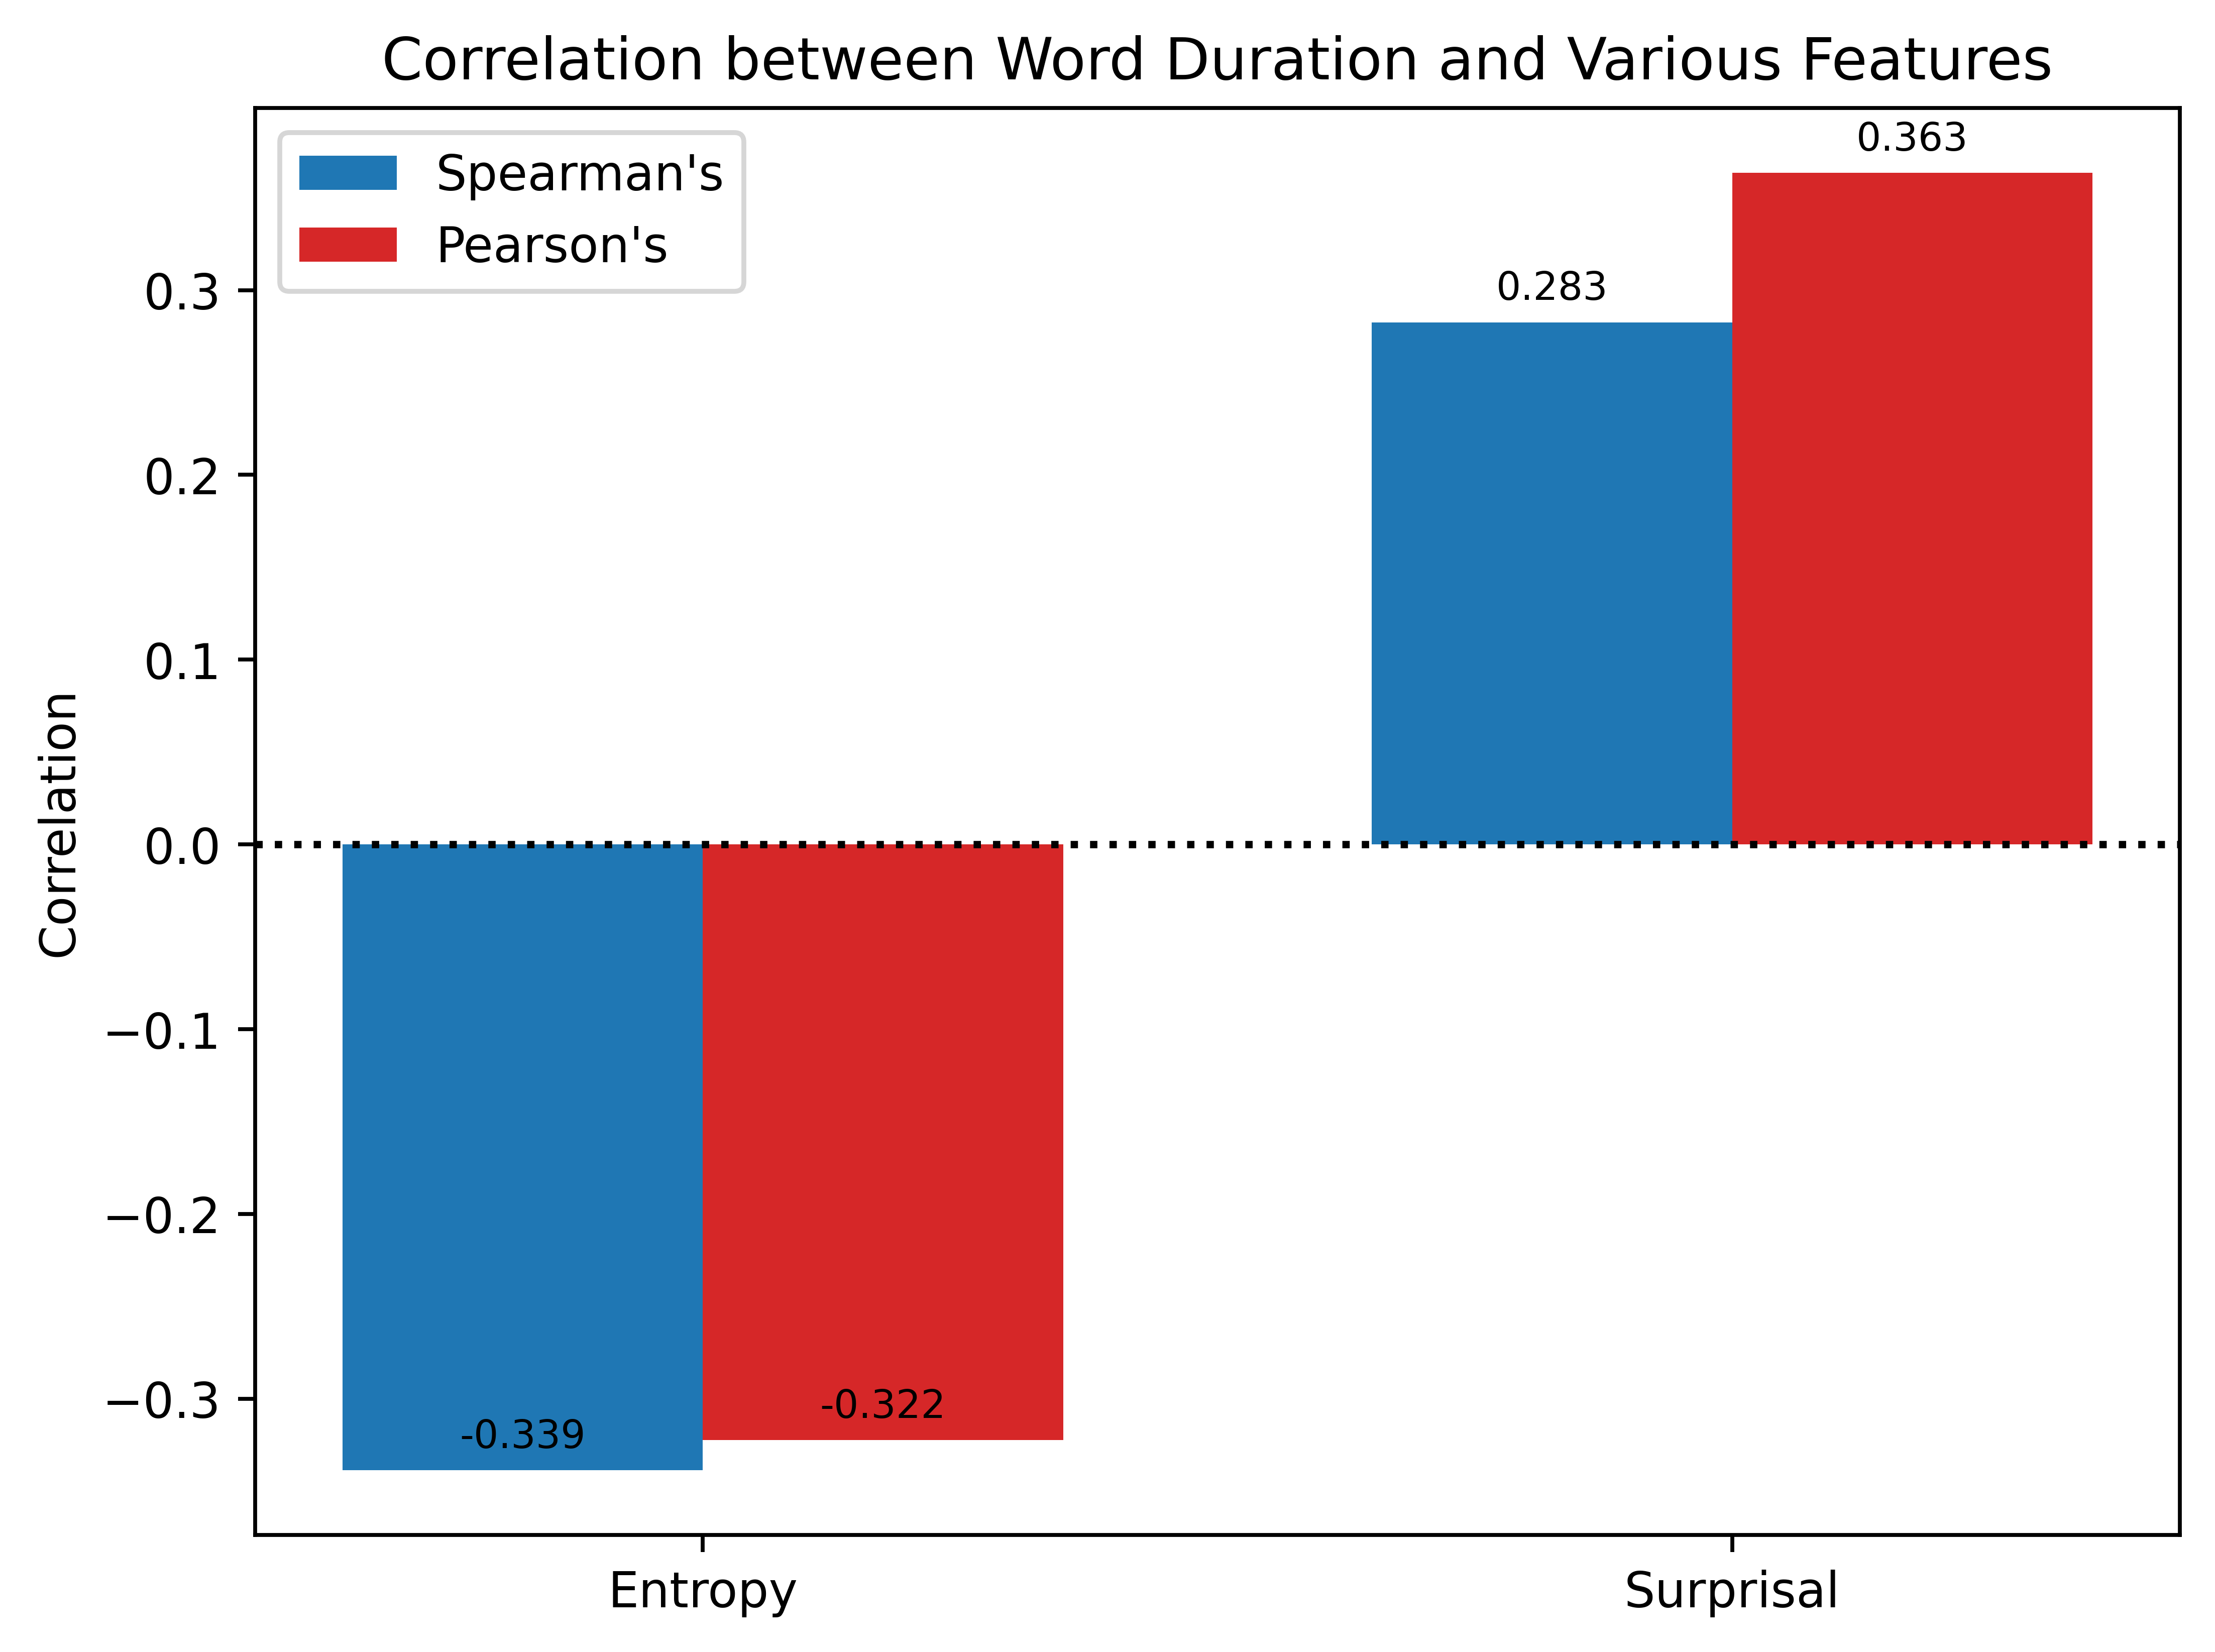

In [45]:
from scipy.stats import spearmanr, pearsonr
from src.utils.plots import plot_correlations

# Calculate correlations and store them in lists
spearman_correlations = []
pearson_correlations = []

for feature, data in zip(
    ["Entropy", "Surprisal"],
    [
        flat_train_token_entropies,
        flat_train_token_surprisal,
    ],
):
    # Calculate Spearman's rank correlation coefficient
    spearman_corr, _ = spearmanr(data, flat_train_labels)
    spearman_correlations.append(spearman_corr)

    # Calculate Pearson's correlation coefficient
    pearson_corr, _ = pearsonr(data, flat_train_labels)
    pearson_correlations.append(pearson_corr)

    print(
        f"Train {feature} and prominence: Spearman's rank correlation coefficient: {spearman_corr}"
    )
    print(
        f"Train {feature} and prominence: Pearson's correlation coefficient: {pearson_corr}"
    )

# Call the function with the lists of feature labels, Spearman correlations, and Pearson correlations
feature_labels = ["Entropy", "Surprisal"]
plot_correlations(
    feature_labels,
    spearman_correlations,
    pearson_correlations,
    title="Correlation between Word Duration and Various Features",
)